In [1]:
import os
os.chdir('..')
!pwd
import bilevel
from bilevel.build_all_models import *
from bilevel.OnlineLinearExpert import *
from bilevel.OnlineTreeExpert import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/Users/krishna/Documents/Research/Simultaneous Classifier/folktables-experiments/multidecomp


# Data viz

In [2]:
df_medical = pd.read_csv('./data_small/insurance.csv')

In [3]:
print(df_medical['sex'].unique(),  df_medical['smoker'].unique(), df_medical['region'].unique(), df_medical['children'].unique())
print(df_medical.describe())

['female' 'male'] ['yes' 'no'] ['southwest' 'southeast' 'northwest' 'northeast'] [0 1 3 2 5 4]
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010


In [4]:
df_medical[df_medical['sex'] == 'male']['charges'].mean(), df_medical[df_medical['sex'] == 'female']['charges'].mean()

(13956.751177721893, 12569.578843835347)

In [5]:
df_medical[df_medical['smoker'] == 'yes']['charges'].mean(), df_medical[df_medical['smoker'] == 'no']['charges'].mean()

(32050.23183153284, 8434.268297856204)

In [13]:
df_medical['smoker'].value_counts()

smoker
no     1064
yes     274
Name: count, dtype: int64

In [10]:
df_medical[df_medical['bmi'] > 30]['charges'].mean(), df_medical[df_medical['bmi'] < 25]['charges'].mean()

(15560.92632126241, 10282.224474367347)

In [12]:
df_medical.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Data scaling

In [9]:
numeric_all = ['age', 'bmi', 'children', 'charges']
cat_all = ['sex', 'smoker', 'region']
df_medical_mm = numeric_scaler(df_medical, numeric_all)
df_medical_mm_oh = one_hot(df_medical_mm, cat_all)
df_medical_mm_oh.drop(cat_all, axis = 1, inplace=True) # drop the categorics that were used to one hot encode
df_medical_mm_oh = df_medical_mm_oh * 1.0 # make bool true, false into 1.0, 0.0
df_medical_mm_oh.head()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,0.021739,0.321227,0.0,0.251611,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.000000,0.479150,0.2,0.009636,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.217391,0.458434,0.6,0.053115,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.326087,0.181464,0.0,0.333010,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.304348,0.347592,0.0,0.043816,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


In [14]:
df_medical_mm_oh.describe()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,0.461022,0.395572,0.218984,0.193916,0.494768,0.505232,0.795217,0.204783,0.242152,0.242900,0.272048,0.242900
std,0.305434,0.164062,0.241099,0.193301,0.500160,0.500160,0.403694,0.403694,0.428546,0.428995,0.445181,0.428995
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.195652,0.278080,0.000000,0.057757,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.456522,0.388485,0.200000,0.131849,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.717391,0.504002,0.400000,0.247700,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
X_dat = df_medical_mm_oh.drop('charges', axis=1)
y_dat = df_medical_mm_oh['charges']

from sklearn.linear_model import LinearRegression, Ridge
ridge = Ridge()
ridge.fit(X_dat, y_dat)
print("ridge score", ridge.score(X_dat, y_dat))

lr = LinearRegression()
lr.fit(X_dat, y_dat)
print("lr score", lr.score(X_dat, y_dat))

ridge score 0.7508822838629774
lr score 0.7433258088081168


In [90]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(max_depth= 2)
dtr.fit(X_dat, y_dat)
dtr.score(X_dat, y_dat)

0.827363054973973

In [45]:
filter_group = ['sex_male', 'sex_female', 'smoker_no', 'smoker_yes']

In [46]:
# tranining on data for only each group
from sklearn.model_selection import train_test_split
random_seed = 21
X_train, X_test, y_train, y_test = train_test_split(X_dat, 
                                                    y_dat, test_size = 0.2,
                                                    shuffle=True, random_state= random_seed)

models_lr_dict = {}
group_sizes = {}

for g in filter_group:
    indices = (X_train[g] == 1)
    model_lr = LinearRegression()
    model_lr.fit(X_train[indices], y_train[indices])
    key = g
    group_sizes[key] = indices.sum() #sum of all the trues
    models_lr_dict[key] = model_lr

In [47]:
for g in filter_group:
    indices = (X_test[g] == 1)
    key = g
    r2_score_lr = models_lr_dict[key].score(X_test[indices], y_test[indices])
    print(f" {key}, test group size {group_sizes[key]}  r2 score for least squares is {r2_score_lr:.4f}")

 sex_male, test group size 545  r2 score for least squares is 0.7740
 sex_female, test group size 525  r2 score for least squares is 0.6788
 smoker_no, test group size 855  r2 score for least squares is 0.3335
 smoker_yes, test group size 215  r2 score for least squares is 0.7120


In [49]:
def cross_test_models(model_dict: dict):
    '''
        model_dict: maps keys to linear model, these linear models are already trained and have weights
        sex_cats: labels for the different sexes
        race_cats: labels for the different races
        This function computes the performance of one model on another models data

        With an example, model_dict['SEX_1'] has the linear model trained only of those points which have SEX == 1
        we will test its performance on all the other groups data.
    '''
    keys = list(model_dict.keys())
    l = len(keys)
    mat_2d = np.zeros((l, l))
    for i in range(l):
        model_i = model_dict[keys[i]]
        for j in range(l):
            key = keys[j]
            indices_j = (X_test[key] == 1)
            mat_2d[i, j] = model_i.score(X_test[indices_j], y_test[indices_j]) # how model i performs on test data meant for model j, R2 score
    return mat_2d, keys

In [50]:
import numpy as np
crossmat, keys = cross_test_models(models_lr_dict)
print(crossmat, keys)

[[  0.77395713   0.67423761   0.2718629    0.34950263]
 [  0.77813946   0.67880169   0.25524712   0.39194409]
 [ -0.20102872  -0.14835755   0.33352264  -4.64742037]
 [ -2.0494803   -3.80947698 -17.23561065   0.71200909]] ['sex_male', 'sex_female', 'smoker_no', 'smoker_yes']


<Axes: >

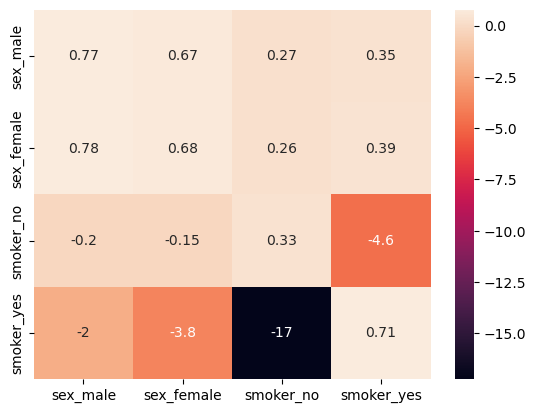

In [51]:
import seaborn as sns # for data visualization
sns.heatmap(crossmat, annot=True, xticklabels=keys, yticklabels=keys)

In [63]:
A_t_ss = pd.concat([df_medical['sex'] == 'male', df_medical['sex'] == 'female', 
                    df_medical['smoker'] == 'yes', df_medical['smoker']=='no'],
                    axis = 1).to_numpy()

A_t_ss = np.hstack((A_t_ss, np.ones((A_t_ss.shape[0],1)))) # adding the always on

In [65]:
np.all(A_t_ss.sum(axis = 1) == 3), np.sum(A_t_ss, axis = 0)

(True, array([ 676.,  662.,  274., 1064., 1338.]))

In [66]:
X_dat.head(), y_dat.head()

(        age       bmi  children  sex_female  sex_male  smoker_no  smoker_yes  \
 0  0.021739  0.321227       0.0         1.0       0.0        0.0         1.0   
 1  0.000000  0.479150       0.2         0.0       1.0        1.0         0.0   
 2  0.217391  0.458434       0.6         0.0       1.0        1.0         0.0   
 3  0.326087  0.181464       0.0         0.0       1.0        1.0         0.0   
 4  0.304348  0.347592       0.0         0.0       1.0        1.0         0.0   
 
    region_northeast  region_northwest  region_southeast  region_southwest  
 0               0.0               0.0               0.0               1.0  
 1               0.0               0.0               1.0               0.0  
 2               0.0               0.0               1.0               0.0  
 3               0.0               1.0               0.0               0.0  
 4               0.0               1.0               0.0               0.0  ,
 0    0.251611
 1    0.009636
 2    0.053115
 3  

In [12]:
# Sex group
# X_dat = df_medical_mm_oh.drop('charges', axis=1)
# y_dat = df_medical_mm_oh['charges']

dirname = './models_adult/baseline/'
# filename = 'ls_medical_ss'
filename = 'ridge_medical_ss'

# expridge = OnlineLinearExpert(X_dat, y_dat, l2_pen = 0.0)
expridge = OnlineLinearExpert(X_dat, y_dat, l2_pen = 1.0)
b_ridgebase = build_baseline_alwayson(dirname, filename, A_t_ss, expridge)

dirname = './models_adult/Anh/'

# experts = [OnlineLinearExpert(X_dat, y_dat, l2_pen = 0.0) for _ in range(A_t_ss.shape[1])]
experts = [OnlineLinearExpert(X_dat, y_dat, l2_pen = 1.0) for _ in range(A_t_ss.shape[1])]
b_Anh = build_Anh(dirname, filename, A_t_ss, experts)

NameError: name 'A_t_ss' is not defined

In [68]:
# with ls experts
cumloss_groupwise_ada = b_Anh.Anh.cumloss_groupwise_ada
cumloss_base = b_ridgebase.expert.cumloss_groupwise
count_ada_better = 0
for g_ind in range(A_t_ss.shape[1]):
    base = cumloss_base[g_ind][-1]
    ada = cumloss_groupwise_ada[g_ind][-1]
    if base >= ada:
        count_ada_better += 1
    print(g_ind, base, ada , base >= ada)
print(count_ada_better)

0 9.340432693981805 9.056613923934176 True
1 7.870279204337945 7.775014640401702 True
2 9.819313779250635 9.599300260487292 True
3 7.391398119069116 7.232328303848592 True
4 17.210711898319786 16.831628564335887 True
5


In [70]:
# with ridge experts
cumloss_groupwise_ada = b_Anh.Anh.cumloss_groupwise_ada
cumloss_base = b_ridgebase.expert.cumloss_groupwise
count_ada_better = 0
for g_ind in range(A_t_ss.shape[1]):
    base = cumloss_base[g_ind][-1]
    ada = cumloss_groupwise_ada[g_ind][-1]
    if base >= ada:
        count_ada_better += 1
    print(g_ind, base, ada , base >= ada)
print(count_ada_better)

0 17.882773372793633 10.663511133777103 True
1 13.526108453162125 9.31153111995223 True
2 20.204301634660876 10.864175680568108 True
3 11.204580191294857 9.110866573161221 True
4 31.40888182595572 19.97504225372932 True
5


In [78]:
dirname = './models_adult/baseline/'
# filename = 'ls_medical_ss'
# filename = 'ridge_medical_ss'
filename = 'htree_medical_ss'


# expridge = OnlineLinearExpert(X_dat, y_dat, l2_pen = 0.0)
X_dat_dict = X_dat.to_dict(orient='records')
expridge = OnlineHoeffdingTree(X_dat_dict, y_dat)
b_tree = build_baseline_alwayson(dirname, filename, A_t_ss, expridge)

dirname = './models_adult/Anh/'

# experts = [OnlineLinearExpert(X_dat, y_dat, l2_pen = 0.0) for _ in range(A_t_ss.shape[1])]
experts = [OnlineHoeffdingTree(X_dat_dict, y_dat) for _ in range(A_t_ss.shape[1])]
b_Anh_tree = build_Anh(dirname, filename, A_t_ss, experts)

100%|██████████| 1338/1338 [00:00<00:00, 1489.04it/s]


In [79]:
# with ridge experts
cumloss_groupwise_ada = b_Anh_tree.Anh.cumloss_groupwise_ada
cumloss_base = b_tree.expert.cumloss_groupwise
count_ada_better = 0
for g_ind in range(A_t_ss.shape[1]):
    base = cumloss_base[g_ind][-1]
    ada = cumloss_groupwise_ada[g_ind][-1]
    if base >= ada:
        count_ada_better += 1
    print(g_ind, base, ada , base >= ada)
print(count_ada_better)

0 9.343638190986532 7.736458565350479 True
1 7.806205459038698 7.180528557457914 True
2 9.598916699896055 7.906813881133385 True
3 7.550926950129177 7.010173241675015 True
4 17.149843650025264 14.916987122808399 True
5


# Groups 
- Age: young, middle , old aged
- Bmi: under, healthy, over, obese weight
- Smoker: yes, no
- Sex: male, female

In [16]:
df_medical['age'].describe(), df_medical['bmi'].describe()

(count    1338.000000
 mean       39.207025
 std        14.049960
 min        18.000000
 25%        27.000000
 50%        39.000000
 75%        51.000000
 max        64.000000
 Name: age, dtype: float64,
 count    1338.000000
 mean       30.663397
 std         6.098187
 min        15.960000
 25%        26.296250
 50%        30.400000
 75%        34.693750
 max        53.130000
 Name: bmi, dtype: float64)

<Axes: >

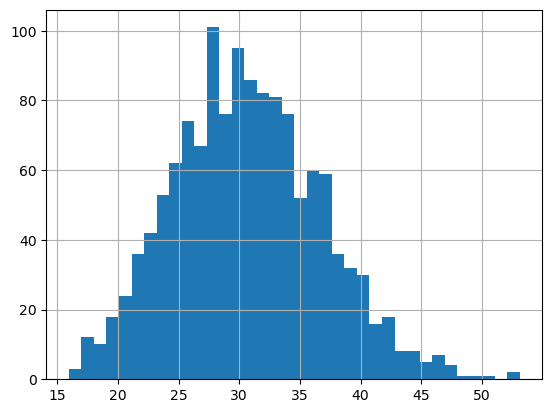

In [17]:
df_medical['bmi'].hist(bins=50-15+1)

In [13]:
A_t_age = pd.concat([df_medical['age'] <= 35,  # young
        (df_medical['age'] > 35) & (df_medical['age'] <= 50), # middle
        df_medical['age'] > 50], # old
             axis = 1, keys = ['young', 'middle', 'old'])


A_t_bmi = pd.concat([df_medical['bmi'] < 18.5,  # underweight
        (df_medical['bmi'] >= 18.5) & (df_medical['bmi'] < 25), # healthy
        (df_medical['bmi'] >= 25) & (df_medical['bmi'] < 30), # overweight 
        df_medical['bmi'] >= 30],  # obese
             axis = 1, keys = ['underweight', 'healthyweight', 'overweight', 'obese'])   

A_t_smoker = pd.concat([df_medical['smoker'] == 'yes', df_medical['smoker'] == 'no'], axis = 1, keys = ['smoker', 'non-smoker'])


A_t_sex = pd.concat([df_medical['sex'] == 'male', df_medical['sex'] == 'female'], axis = 1, keys = ['male', 'female'])

# A_t_age, A_t_bmi, A_t_smoker, A_t_sex

In [14]:
A_t_medical_groups = pd.concat([A_t_age, A_t_bmi, A_t_smoker, A_t_sex], axis=1)

In [15]:
A_t_medical_groups.sum(axis=1).unique()

array([4])

In [22]:
A_t_medical_groups.sum(axis=0)

young             574
middle            408
old               356
underweight        20
healthyweight     225
overweight        386
obese             707
smoker            274
non-smoker       1064
male              676
female            662
dtype: int64

In [16]:
A_t_medical_groups['always_on'] = True
A_t_medical_groups *= 1.0

In [17]:
A_t_medical_groups.sum(axis=0)

young             574.0
middle            408.0
old               356.0
underweight        20.0
healthyweight     225.0
overweight        386.0
obese             707.0
smoker            274.0
non-smoker       1064.0
male              676.0
female            662.0
always_on        1338.0
dtype: float64

In [24]:
A_t_medical_groups

,young,middle,old,underweight,healthyweight,overweight,obese,smoker,non-smoker,male,female,always_on
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1333,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
1334,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
1335,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
1336,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0


In [59]:
# code for plotting the regret curves
from sklearn.linear_model import LinearRegression, Ridge

def plot_Anh_minus_besthindsight(cl_ada_g: np.array, cl_metaexp_g: np.array, X_dat_g, y_dat_g, num_points = 10):
    '''
        cl_ada_g: array of shape (Tg,) having the cumulative loss of Anh on this group subsequence
        cl_metaexp_g: array of shape (Tg,) having the cumulative loss of this group meta expert
        X_dat_g: rows of the original dataframe where only group g is active
    '''
    Tg = len(X_dat_g)
#     print(Tg, cl_ada_g.shape, cl_metaexp_g.shape)
    sse = [] # sum of squared errors for the best in hindsight, saved in this
    thetasq = [] # thetanorm squared
    pos = np.linspace(Tg // num_points, Tg-1, dtype = int, num = num_points) # positions in the dataframe to find best in hindsight 
    for p in pos:
        X_batch = X_dat_g[:p]
        y_batch = y_dat_g[:p]
#         lr = LinearRegression()
#         lr.fit(X_batch, y_batch)
#         sse.append(np.sum((lr.predict(X_batch) - y_batch)**2))
#         thetasq.append(np.linalg.norm(lr.coef_)**2)
        ridge = Ridge()
        ridge.fit(X_batch, y_batch)
        sse.append(np.sum((ridge.predict(X_batch) - y_batch)**2))
        thetasq.append(np.linalg.norm(ridge.coef_)**2)
    sse = np.array(sse)
    thetasq = np.array(thetasq)
    # print(f"pos : {pos}")
    # print(f"cl ada: {cl_ada_g[pos]}")
    # print(f"cl meta exp: {cl_metaexp_g[pos]}")
    # print(f"sse {sse}")
    # print(f"thetasq  {thetasq}")
    # print(f"Anh group - best hindsight loss {(cl_ada_g[pos] - sse)}")
    # print(f"group meta exp - best hindsight loss {(cl_metaexp_g[pos] - sse)}")
    # print(pos, cl_metaexp_g[pos] - sse -thetasq)
    plt.plot(pos, cl_ada_g[pos] - sse - thetasq, label = 'ada group regret')
    plt.legend()
    plt.show()

    plt.plot(pos, thetasq, label = 'theta_norm_sq')
    plt.legend()
    plt.show()
    # plt.plot(pos, cl_ada_g[pos] - sse, label = 'ada group regret')
    # plt.plot(pos, cl_metaexp_g[pos] - sse, label = 'meta exp regret')
    # plt.plot(pos, pos**0.5, label = 'sqrt pos')
    # plt.legend()
    # plt.show()


In [51]:
A_t_med_shuf = A_t_medical_groups.to_numpy()
X_dat = df_medical_mm_oh.drop('charges', axis=1)
y_dat = df_medical_mm_oh['charges']

dirname = './models_adult/baseline/'
filename = 'ridge_medical_regretinvestigation'

expridge = OnlineLinearExpert(X_dat, y_dat, l2_pen = 1.0)
b_ridgebase = build_baseline_alwayson(dirname, filename, A_t_med_shuf, expridge)
dirname = './models_adult/Anh/'
experts = [OnlineLinearExpert(X_dat, y_dat, l2_pen = 1.0) for _ in range(A_t_med_shuf.shape[1])]
b_Anh = build_Anh(dirname, filename, A_t_med_shuf, experts)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1338/1338 [00:05<00:00, 259.93it/s]


In [34]:
A_t_med_shuf.shape, A_t_medical_groups.shape, df_medical_mm_oh.shape

((1338, 12), (1338, 12), (1338, 12))

young 574


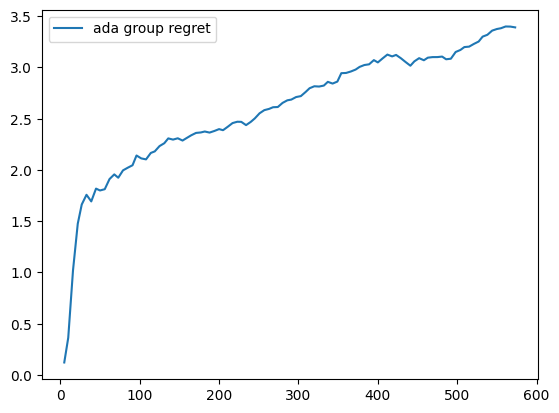

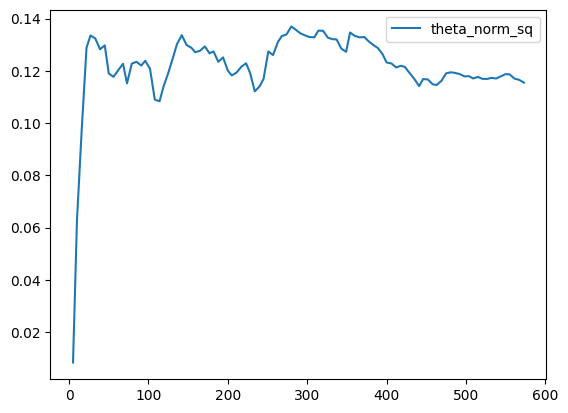

middle 408


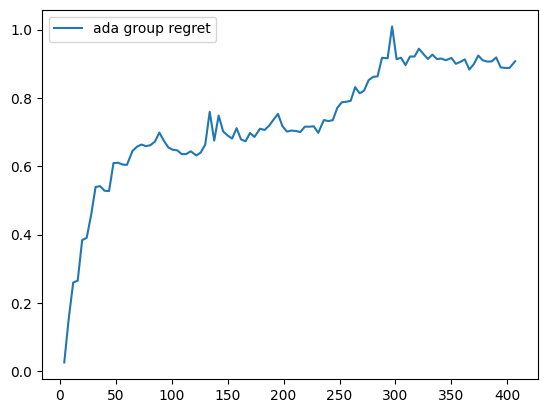

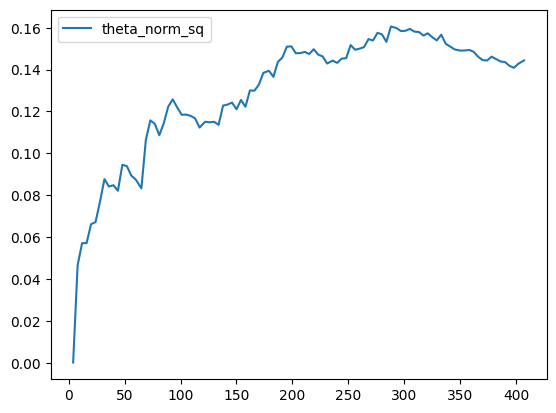

old 356


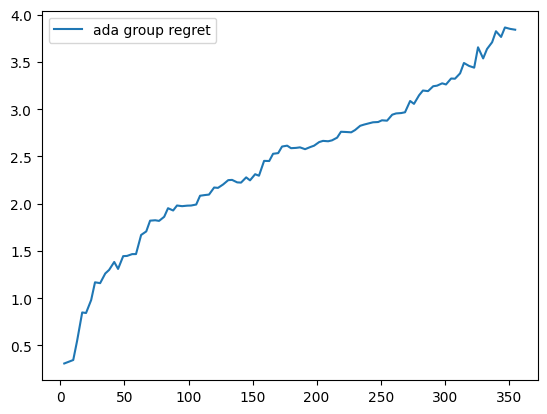

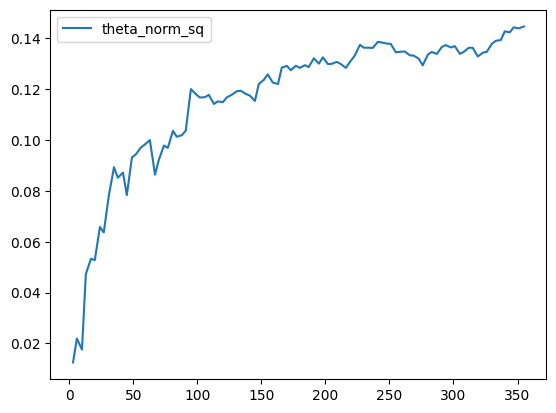

underweight 20


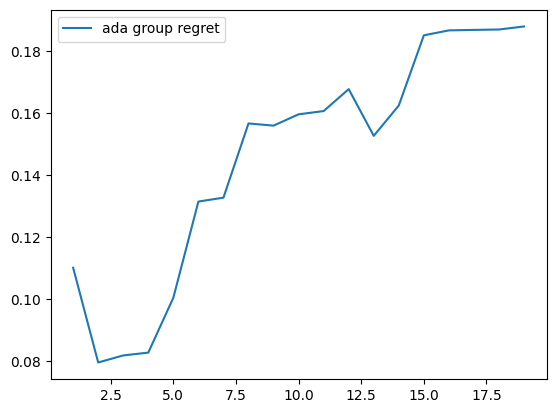

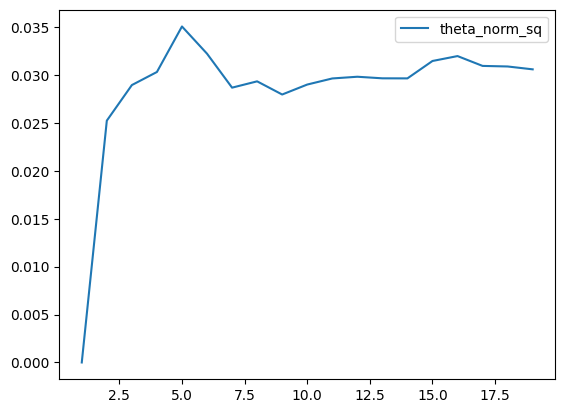

healthyweight 225


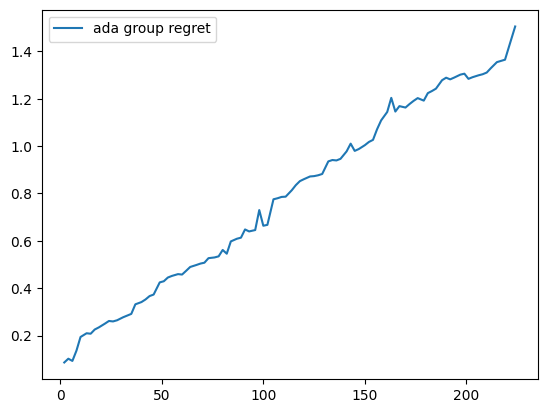

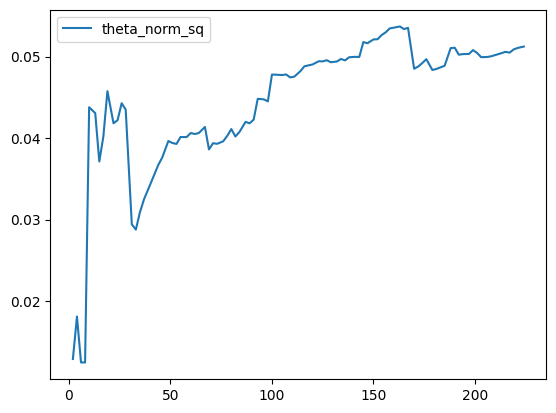

overweight 386


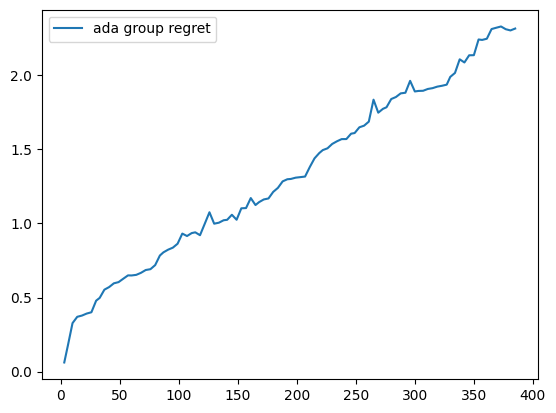

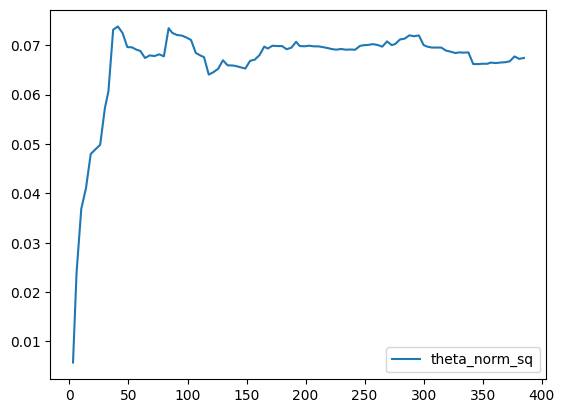

obese 707


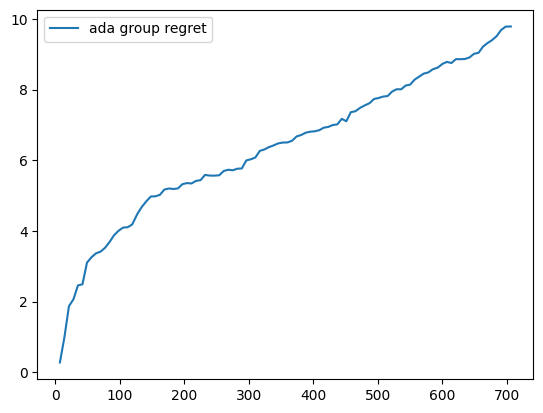

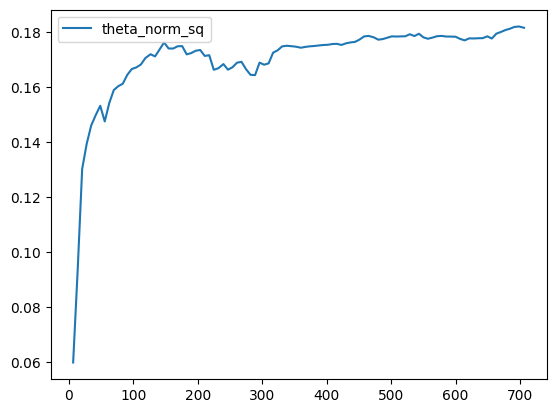

smoker 274


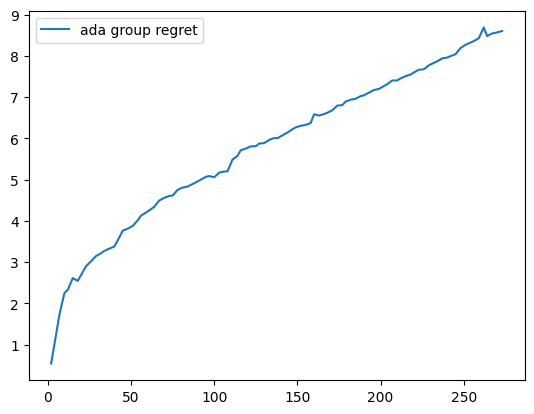

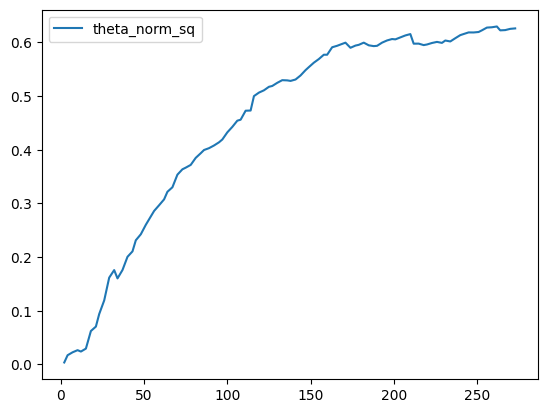

non-smoker 1064


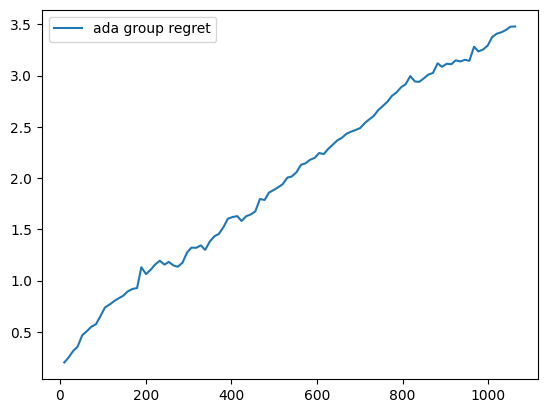

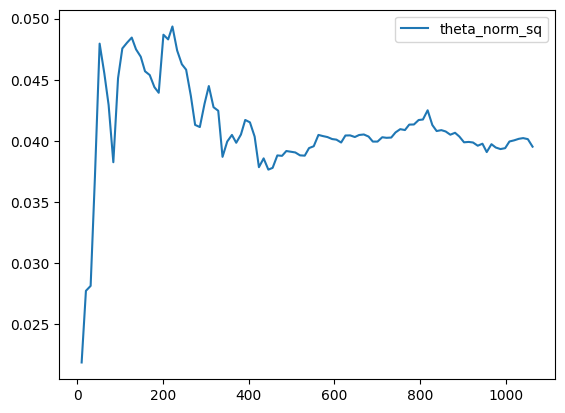

male 676


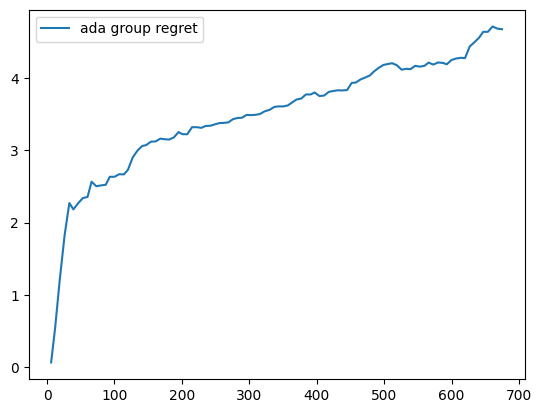

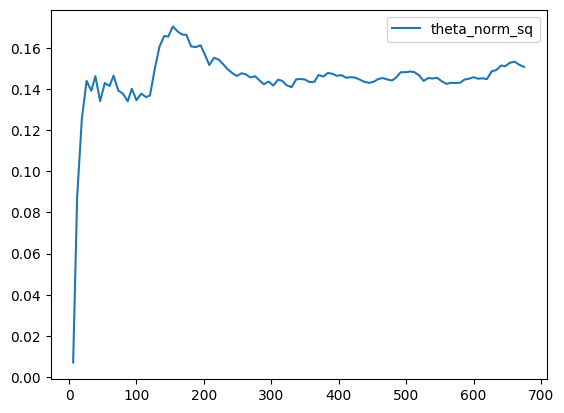

female 662


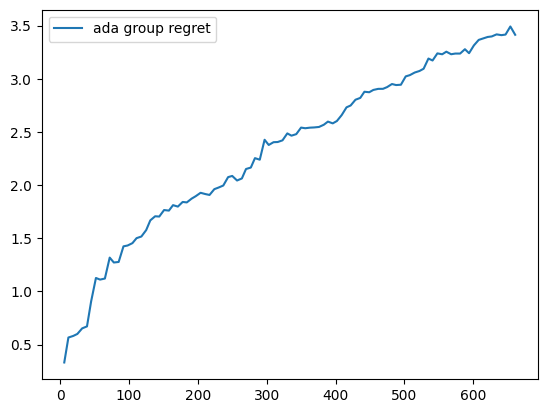

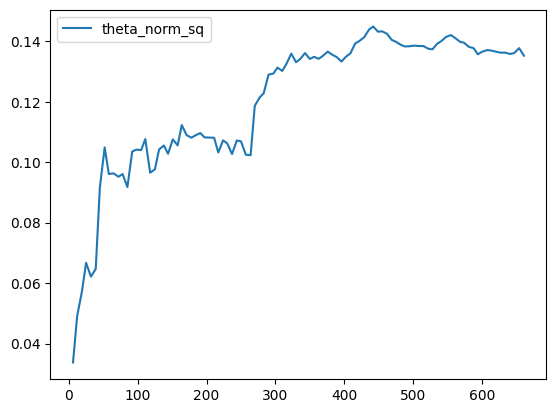

always_on 1338


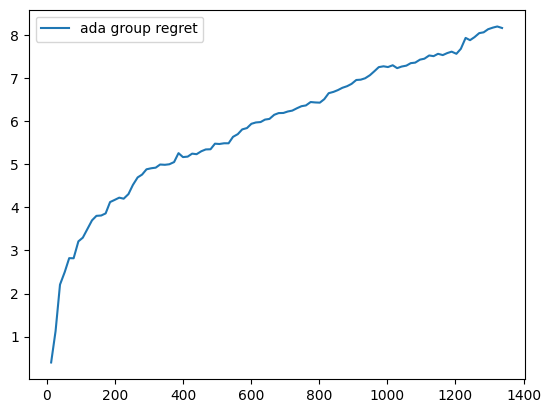

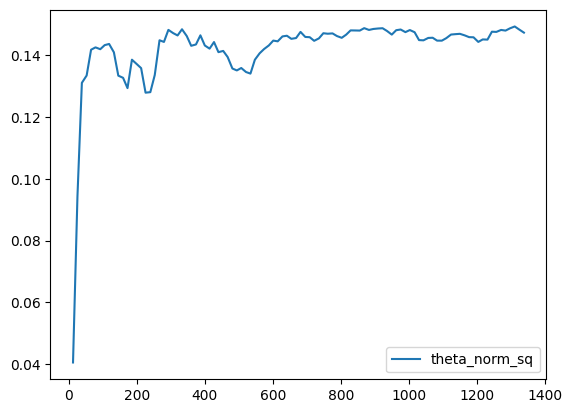

In [60]:
# cl_group_metaexp = Anhrm.cumloss_groupwise_metaexp TODO
Anh = b_Anh.Anh
for g_ind, gname in enumerate(A_t_medical_groups.columns):
    indices_g = (A_t_medical_groups[gname] == 1)
    X_dat_g = df_medical_mm_oh[indices_g].drop('charges', axis=1)
    y_dat_g = df_medical_mm_oh[indices_g]['charges']
    Tg = X_dat_g.shape[0]
    print(gname, Tg)
    plot_Anh_minus_besthindsight(Anh.cumloss_groupwise_ada[g_ind],
                                 Anh.cumloss_groupwise_metaexp[g_ind], X_dat_g, y_dat_g, 
                                 num_points = min(100, Tg))

In [ ]:
    X_dat = df_med_shuf.drop('charges', axis=1)
    y_dat = df_med_shuf['charges']

## Now we take 10 random seeds and shuffle the dataframe, group indicators and report mean and std for group subsequence cum loss

stick to these random seeds

In [51]:
# np.random.randint(100, 1000, size = 10)
rand_seeds = [473, 503, 623, 550, 692, 989, 617, 458, 301, 205] # 10 random seeds used to shuffle the df_medical mm oh dataframe, A_t_medical_groups
# rand_seeds = [473, 503, 623]

In [52]:
med_group_names = ['age_young', 'age_middle', 'age_old', \
'bmi_underweight', 'bmi_healthyweight', 'bmi_overweight','bmi_obese', 'smoker_yes', 'smoker_no',\
 'sex_male', 'sex_female', 'always_on']
print(med_group_names, len(med_group_names))

def add_to_dic_res(b_ridgebase, b_Anh):
    cumloss_base = b_ridgebase.expert.cumloss_groupwise
    cumloss_groupwise_ada = b_Anh.Anh.cumloss_groupwise_ada
    num_group = len(b_Anh.Anh.experts)
    for g_ind, gname in enumerate(med_group_names):
        base = cumloss_base[g_ind][-1]
        ada = cumloss_groupwise_ada[g_ind][-1]
        # dic_res[gname + '_base'].append(base)
        # dic_res[gname + '_Anh'].append(ada)
        dic_res_base[gname].append(base)
        dic_res_Anh[gname].append(ada)

['age_young', 'age_middle', 'age_old', 'bmi_underweight', 'bmi_healthyweight', 'bmi_overweight', 'bmi_obese', 'smoker_yes', 'smoker_no', 'sex_male', 'sex_female', 'always_on'] 12


In [53]:
from collections import defaultdict
dic_res_base = defaultdict(list)
dic_res_Anh = defaultdict(list)
for seed in rand_seeds:
    df_med_shuf = df_medical_mm_oh.sample(frac=1, random_state = seed)
    A_t_med_shuf = A_t_medical_groups.sample(frac=1, random_state = seed).to_numpy()
    X_dat = df_med_shuf.drop('charges', axis=1)
    y_dat = df_med_shuf['charges']

    dirname = './models_adult/baseline/'
    filename = 'ridge_medical'+str(seed)

    expridge = OnlineLinearExpert(X_dat, y_dat, l2_pen = 1.0)
    b_ridgebase = build_baseline_alwayson(dirname, filename, A_t_med_shuf, expridge)
    dirname = './models_adult/Anh/'
    experts = [OnlineLinearExpert(X_dat, y_dat, l2_pen = 1.0) for _ in range(A_t_med_shuf.shape[1])]
    b_Anh = build_Anh(dirname, filename, A_t_med_shuf, experts)
    add_to_dic_res(b_ridgebase, b_Anh)


100%|██████████| 1338/1338 [00:11<00:00, 117.64it/s]


In [54]:
df_res_base, df_res_Anh = pd.DataFrame(dic_res_base), pd.DataFrame(dic_res_Anh)

In [65]:
df_res_base

,age_young,age_middle,age_old,bmi_underweight,bmi_healthyweight,bmi_overweight,bmi_obese,smoker_yes,smoker_no,sex_male,sex_female,always_on
0,12.716662,8.312681,10.228661,0.202999,2.167323,3.873005,25.014677,20.262270,10.995734,18.228023,13.029980,31.258004
1,13.166035,8.503464,9.669571,0.217518,2.096492,3.921234,25.103825,20.217901,11.121169,17.889630,13.449440,31.339070
2,12.724306,8.929969,9.572944,0.194247,2.024005,3.981313,25.027654,20.318015,10.909204,17.736454,13.490765,31.227220
3,12.842443,8.494364,9.911603,0.200715,2.111941,3.918095,25.017660,20.139499,11.108911,17.695164,13.553246,31.248410
4,13.149100,8.284646,9.658845,0.206465,2.301757,3.802153,24.782216,20.002551,11.090040,18.142038,12.950553,31.092591
5,12.952846,8.648990,9.691870,0.242177,1.910908,3.825856,25.314765,20.326444,10.967262,17.386027,13.907679,31.293706
6,13.000454,8.915356,9.671898,0.171963,2.156019,3.769578,25.490148,20.643494,10.944215,17.913923,13.673785,31.587708
7,12.773277,8.863737,9.971491,0.241590,2.180550,3.832239,25.354126,20.443673,11.164833,18.155792,13.452714,31.608505
8,12.521129,8.750038,10.039569,0.204751,2.193667,3.957945,24.954373,20.223577,11.087158,18.317434,12.993301,31.310735
9,12.994946,8.419410,9.757121,0.189469,2.341772,3.944556,24.695679,20.094598,11.076878,17.964337,13.207139,31.171476


In [66]:
df_res_Anh

,age_young,age_middle,age_old,bmi_underweight,bmi_healthyweight,bmi_overweight,bmi_obese,smoker_yes,smoker_no,sex_male,sex_female,always_on
0,8.167285,4.781329,7.683668,0.258241,2.648894,4.209957,13.515190,11.569766,9.062516,11.486381,9.145901,20.632282
1,8.603933,5.014588,7.039557,0.269585,2.562380,4.154044,13.672068,11.573429,9.084648,10.540695,10.117382,20.658077
2,8.051917,5.205211,7.198286,0.275412,2.562840,4.095895,13.521266,11.522104,8.933309,10.603553,9.851860,20.455413
3,8.340445,5.027272,7.254324,0.257840,2.629848,3.981652,13.752700,11.498002,9.124038,10.473046,10.148994,20.622040
4,8.384005,4.722982,7.055241,0.283740,2.750092,4.060655,13.067742,11.195032,8.967197,11.059639,9.102590,20.162229
5,8.525284,4.903011,7.272264,0.271272,2.500451,3.981803,13.947033,11.721976,8.978583,10.403161,10.297398,20.700559
6,8.569920,5.390504,6.990863,0.261357,2.565187,4.099793,14.024950,11.933993,9.017294,10.369254,10.582033,20.951287
7,7.573233,5.465201,7.457036,0.208255,2.648030,4.043910,13.595275,11.491046,9.004424,11.153194,9.342276,20.495470
8,7.875225,5.049824,7.467334,0.271840,2.679062,4.113122,13.328360,11.502037,8.890346,11.167158,9.225225,20.392383
9,8.693160,4.839161,7.084035,0.226987,2.858663,4.126310,13.404395,11.666379,8.949976,11.253976,9.362379,20.616355


In [67]:
df_res_base >= df_res_Anh

,age_young,age_middle,age_old,bmi_underweight,bmi_healthyweight,bmi_overweight,bmi_obese,smoker_yes,smoker_no,sex_male,sex_female,always_on
0,True,True,True,False,False,False,True,True,True,True,True,True
1,True,True,True,False,False,False,True,True,True,True,True,True
2,True,True,True,False,False,False,True,True,True,True,True,True
3,True,True,True,False,False,False,True,True,True,True,True,True
4,True,True,True,False,False,False,True,True,True,True,True,True
5,True,True,True,False,False,False,True,True,True,True,True,True
6,True,True,True,False,False,False,True,True,True,True,True,True
7,True,True,True,True,False,False,True,True,True,True,True,True
8,True,True,True,False,False,False,True,True,True,True,True,True
9,True,True,True,False,False,False,True,True,True,True,True,True


In [55]:
df_res_base.describe().loc[['mean', 'std']]

,age_young,age_middle,age_old,bmi_underweight,bmi_healthyweight,bmi_overweight,bmi_obese,smoker_yes,smoker_no,sex_male,sex_female,always_on
mean,12.884120,8.612265,9.817357,0.207189,2.148443,3.882598,25.075512,20.267202,11.046540,17.942882,13.370860,31.313743
std,0.205372,0.244128,0.210403,0.021865,0.124860,0.072346,0.249867,0.182369,0.085708,0.283781,0.316696,0.165665


In [56]:
df_base_meansd = df_res_base.describe().loc[['mean', 'std']]
df_Anh_meansd = df_res_Anh.describe().loc[['mean', 'std']]

In [58]:
df_base_temp, df_Anh_temp = df_base_meansd.T, df_Anh_meansd.T

In [59]:
df_base_temp.rename(columns={'mean': 'mean_base', 'std': 'std_base'}, inplace=True)
df_Anh_temp.rename(columns={'mean': 'mean_Anh', 'std': 'std_Anh'}, inplace=True)


In [60]:
age_res_cols = ['age_young', 'age_middle', 'age_old']
bmi_res_cols = ['bmi_underweight', 'bmi_healthyweight', 'bmi_overweight', 'bmi_obese']
smoker_res_cols = ['smoker_yes','smoker_no']
sex_res_cols = ['sex_male', 'sex_female']
always_res_cols = ['always_on']

In [61]:
df_base_temp_age = df_base_temp.loc[age_res_cols]
df_Anh_temp_age = df_Anh_temp.loc[age_res_cols]


df_base_temp_bmi = df_base_temp.loc[bmi_res_cols]
df_Anh_temp_bmi = df_Anh_temp.loc[bmi_res_cols]


In [62]:
df_age_res = pd.concat([df_base_temp_age, df_Anh_temp_age], axis =1)
df_bmi_res = pd.concat([df_base_temp_bmi, df_Anh_temp_bmi], axis =1)

In [43]:
df_age_res, df_bmi_res

(            mean_base  std_base  mean_Anh   std_Anh
 age_young   12.869001  0.257268  8.274378  0.291174
 age_middle   8.582038  0.316056  5.000376  0.212298
 age_old      9.823725  0.353997  7.307170  0.335577,
                    mean_base  std_base   mean_Anh   std_Anh
 bmi_underweight     0.204921  0.011754   0.267746  0.008732
 bmi_healthyweight   2.095940  0.071660   2.591372  0.049817
 bmi_overweight      3.925184  0.054262   4.153299  0.057035
 bmi_obese          25.048719  0.048163  13.569508  0.088872)

In [38]:
row_names = {'age_young':'young',
             'age_middle':'middle',
             'age_old':'old'}

df_age_res = df_age_res.rename(index = row_names)

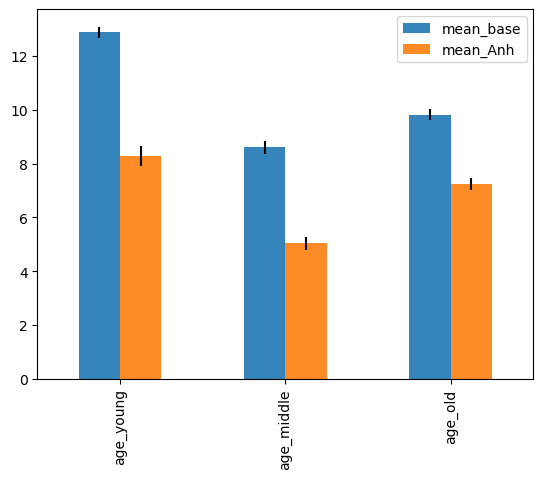

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

yerr = df_age_res[['std_base', 'std_Anh']].to_numpy().T

df_age_res[['mean_base', 'mean_Anh']].plot(kind='bar', yerr=yerr, alpha=0.9, error_kw=dict(ecolor='k'))
plt.show()

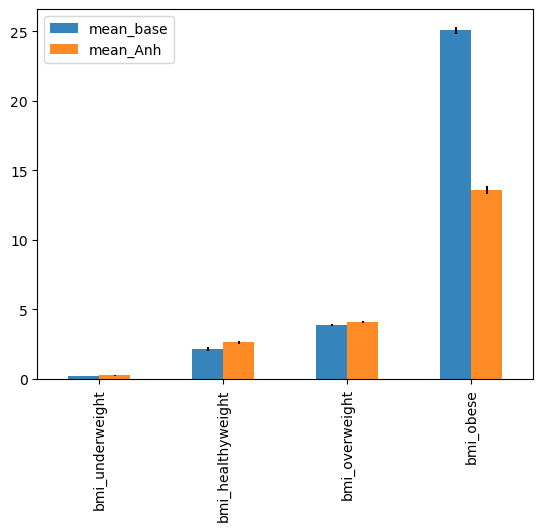

In [63]:
yerr = df_bmi_res[['std_base', 'std_Anh']].to_numpy().T

df_bmi_res[['mean_base', 'mean_Anh']].plot(kind='bar', yerr=yerr, alpha=0.9, error_kw=dict(ecolor='k'))
plt.show()

In [236]:
age_res_cols = ['age_young_base', 'age_young_Anh', 'age_middle_base', 'age_middle_Anh',
       'age_old_base', 'age_old_Anh']

bmi_res_cols = ['bmi_underweight_base','bmi_underweight_Anh', 'bmi_healthyweight_base', 'bmi_healthyweight_Anh', 
'bmi_overweight_base', 'bmi_overweight_Anh','bmi_obese_base', 'bmi_obese_Anh']

smoker_res_cols = ['smoker_yes_base', 'smoker_yes_Anh',
       'smoker_no_base', 'smoker_no_Anh']

sex_res_cols = ['sex_male_base', 'sex_male_Anh',
       'sex_female_base', 'sex_female_Anh']


always_res_cols = ['always_on_base', 'always_on_Anh']

In [235]:
df_res_stat.columns

Index(['age_young_base', 'age_young_Anh', 'age_middle_base', 'age_middle_Anh',
       'age_old_base', 'age_old_Anh', 'bmi_underweight_base',
       'bmi_underweight_Anh', 'bmi_healthyweight_base',
       'bmi_healthyweight_Anh', 'bmi_overweight_base', 'bmi_overweight_Anh',
       'bmi_obese_base', 'bmi_obese_Anh', 'smoker_yes_base', 'smoker_yes_Anh',
       'smoker_no_base', 'smoker_no_Anh', 'sex_male_base', 'sex_male_Anh',
       'sex_female_base', 'sex_female_Anh', 'always_on_base', 'always_on_Anh'],
      dtype='object')

In [241]:
def pairwise(iterable):
    "s -> (s0, s1), (s2, s3), (s4, s5), ..."
    a = iter(iterable)
    return zip(a, a)

for x, y in pairwise(bmi_res_cols):
    print(x,y)


bmi_underweight_base bmi_underweight_Anh
bmi_healthyweight_base bmi_healthyweight_Anh
bmi_overweight_base bmi_overweight_Anh
bmi_obese_base bmi_obese_Anh


In [248]:
df_res_stat.T.loc[['bmi_obese_base']]

,mean,std
bmi_obese_base,25.075512,0.249867


In [244]:
df_res_stat.T

,mean,std
age_young_base,12.884120,0.205372
age_young_Anh,8.278441,0.359380
age_middle_base,8.612265,0.244128
age_middle_Anh,5.039908,0.249079
age_old_base,9.817357,0.210403
age_old_Anh,7.250261,0.225652
bmi_underweight_base,0.207189,0.021865
bmi_underweight_Anh,0.258453,0.023365
bmi_healthyweight_base,2.148443,0.124860
bmi_healthyweight_Anh,2.640545,0.104750


In [224]:
v3, v4

(8.278440567340118, 0.3593800623258981)